# 3. Future Scenario Analysis

This notebook uses the best-performing model (determined in `02_model_analysis.ipynb`) to predict future sea level rise based on different GHG emission scenarios. It performs the following steps:
1. Loads the future GHG emission scenario data.
2. Loads the chosen, pre-trained model from the `../models/` directory.
3. Prepares the input sequences for the model based on the future scenarios.
4. Generates predictions for sea level rise up to the year 2050 for each scenario.
5. Visualizes the results and presents them in a final summary table.

### 3.1 Setup and Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [ ]:
%%capture
from ipynb.fs.full.data_exploration import df_sealevel, GHG_past_comb, df_pred

In [ ]:
# Add src directory to path to import neural_networks module
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from neural_networks import NeuralNetwork_0hl, NeuralNetwork_2hl

# Set random seed for reproducibility
np.random.seed(42)

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Prepare the data for normalization and rename the scenarios
df_sealevel = df_sealevel.groupby(df_sealevel.Day.dt.year).mean()
df_sealevel = df_sealevel.drop('Day', axis=1, errors='ignore')

# Create continous yearly data for the GHG scenarios
for year in df_pred.index[:-1]:
    diff = df_pred.loc[year+5] - df_pred.loc[year]
    for i in range(4):
        df_pred.loc[year+i+1] = df_pred.loc[year] + (i+1)*diff/5
df_pred = df_pred.sort_index()

# Store mean/std for denormalization later
ghg_mean = GHG_past_comb.mean().values[0]
ghg_std = GHG_past_comb.std().values[0]
sealevel_mean = df_sealevel.mean().values[0]
sealevel_std = df_sealevel.std().values[0]

# Normalization
GHG_past_norm = (GHG_past_comb - ghg_mean) / ghg_std
GHG_pred_norm = (df_pred - ghg_mean) / ghg_std
sealevel_norm = (df_sealevel - sealevel_mean) / sealevel_std

# Sequence for the input
def get_GHG_sequence_X(n_years, df_GHG, start_year, end_year):
    X = list()
    start_ix = start_year-n_years+1
    for i in range(start_ix,end_year-n_years+2):
        end_ix = i + n_years - 1
        seq_x = df_GHG.loc[i:end_ix]
        X.append(seq_x.to_numpy())
    return np.array(X)

### 3.2 Load Model and Generate Predictions

In [ ]:
# Load the best model
model = NeuralNetwork_2hl.load_model('../models/2hl_model.pkl')

timespan = 15
prediction_years = np.arange(2014, 2051)
results_denorm = {}

for i,scenario in enumerate(GHG_pred_norm.columns):
    # Combine historical data with scenario trends and create the input sequences
    arr_GHG_norm = pd.concat([GHG_past_norm['annual_emissions_ghg_total_co2eq'],GHG_pred_norm[scenario]]).sort_index()
    x_data_norm = get_GHG_sequence_X(timespan,arr_GHG_norm,2014,2050)

    # Predict the sea level for the scenario
    predictions_norm = model.predict(np.array(x_data_norm))

    # Denormalize the predictions
    predictions_denorm = (np.array(predictions_norm) * sealevel_std) + sealevel_mean
    results_denorm[scenario] = predictions_denorm

print('Future predictions generated for all scenarios.')

Future predictions generated for all scenarios.


### 3.3 Visualize and Summarize Results

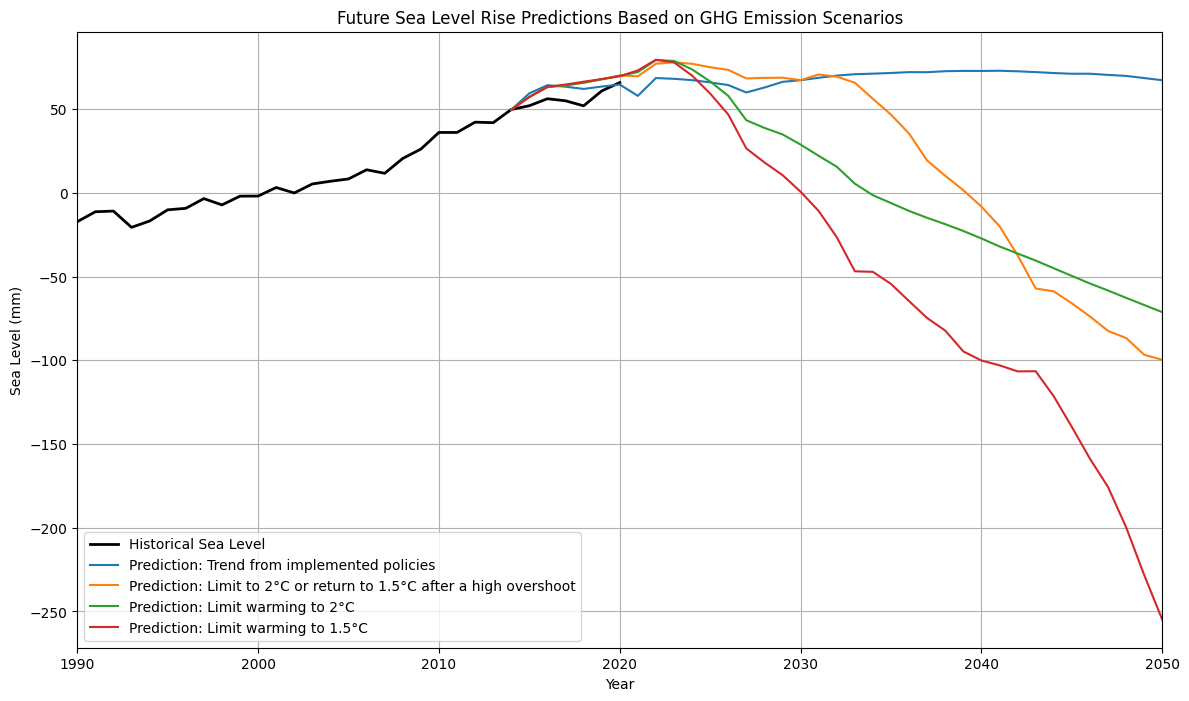

Predicted Sea Level Rise (mm) for Key Years:


In [ ]:
# Plotting the results
plt.figure(figsize=(14, 8))

# Plot historical sea level data
plt.plot(df_sealevel, label='Historical Sea Level', color='black', linewidth=2)

# Plot predictions for each scenario
for scenario, predictions in results_denorm.items():
    plt.plot(prediction_years, predictions, label=f'Prediction: {scenario}')

plt.title('Future Sea Level Rise Predictions Based on GHG Emission Scenarios')
plt.xlabel('Year')
plt.ylabel('Sea Level (mm)')
plt.legend()
plt.grid(True)
plt.xlim(1990, 2050)
plt.show()

# Create a summary table
summary_data = {'Year': prediction_years}
for scenario, predictions in results_denorm.items():
    summary_data[scenario] = np.squeeze(predictions)

df_summary = pd.DataFrame(summary_data).set_index('Year')

# Display the table for key years
print("Predicted Sea Level Rise (mm) for Key Years:")
#print(df_summary.loc[display_years].round(2).to_markdown())